- All of this code practice is based on this programmer (Very helpful to study)
https://www.youtube.com/watch?v=AA621UofTUA&list=LL&index=2

In [3]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.7 MB/s 
     |████████████████████████████████| 1.3 MB 6.4 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


In [4]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [5]:
import spacy 

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰 
spacy_de = spacy.load('de_core_news_sm')

In [6]:
tokenized = spacy_en.tokenizer('I am a graduate student.')

for i , token in enumerate(tokenized):
    print(f"Index {i}: {token.text}") # 토큰으로 바뀜 

Index 0: I
Index 1: am
Index 2: a
Index 3: graduate
Index 4: student
Index 5: .


In [7]:
def tokenize_de(text):
  return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [token.text for token in spacy_en.tokenizer(text)]

In [8]:
from torchtext.data import Field, BucketIterator 

SOURCE = Field(tokenize=tokenize_de, init_token="<sos>",eos_token="<eos>", lower=True, batch_first=True) 
TARGET = Field(tokenize=tokenize_en, init_token="<sos>",eos_token="<eos>",lower=True, batch_first=True)

In [9]:
from torchtext.datasets import Multi30k 

train_dataset , valid_dataset , test_dataset = Multi30k.splits(exts=(".de",".en"), fields=(SOURCE, TARGET))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 932kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 247kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 238kB/s]


In [10]:
print(vars(train_dataset.examples[10])['src']) # 학습 데이터 예제 
print(vars(train_dataset.examples[10])['trg'])

['eine', 'ballettklasse', 'mit', 'fünf', 'mädchen', ',', 'die', 'nacheinander', 'springen', '.']
['a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence', '.']


In [11]:
vars(train_dataset.examples[10]).keys()

dict_keys(['src', 'trg'])

In [12]:
SOURCE.build_vocab(train_dataset, min_freq=2)
TARGET.build_vocab(train_dataset, min_freq=2) # make each vocabulary set

In [13]:
print(len(SOURCE.vocab))
print(len(TARGET.vocab))

7853
5893


In [14]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128 

train_iterator , valid_iterator , test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size= BATCH_SIZE,
    device = device
)

In [15]:
for i , batch in enumerate(train_iterator):
  source = batch.src
  target = batch.trg 
  print(f"first batch size: {source.shape}")

  for i in range(source.shape[1]):
    print(f"index {i}: {source[0][i].item()}")
  break

first batch size: torch.Size([128, 27])
index 0: 2
index 1: 18
index 2: 174
index 3: 30
index 4: 52
index 5: 7
index 6: 6
index 7: 790
index 8: 6277
index 9: 276
index 10: 3301
index 11: 1549
index 12: 10
index 13: 185
index 14: 23
index 15: 4
index 16: 3
index 17: 1
index 18: 1
index 19: 1
index 20: 1
index 21: 1
index 22: 1
index 23: 1
index 24: 1
index 25: 1
index 26: 1


## Multi-head attention 
Mutli-head attention is summing up a number of heads which is generated by self-attention

It gets three inputs. 
Q, K, V - These three of them are actually aiming common things but each of them is used for different purposes. 
1. Q - question 
  -> This information means what does this word(token) means and what happens if we use this? 
2. Key - meaning of this token 
 -> This is mainly used dot product iwth Q in order to extract the meaning of certain Q('th token)
3. Value - The value itself 
 -> I understood this concept as the quantity of each tokens.

In [16]:
import torch.nn as nn 

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads 
        self.head_dim = hidden_dim // self.n_heads # 각 head에서의 embedding 차원을 이렇게 구해줘야한다. 이유는 n times 돌아가기 위해서는 heads를 concat하면 input의 크기와 동일해야하기 때문이다. 
        self.dropout = nn.Dropout(dropout_ratio) 

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, Q, K, V,mask=None):

        batch_size = Q.shape[0] # batch size extract 
       
        Q = self.fc_q(Q)
        K = self.fc_k(K)
        V = self.fc_v(V)
        # n_heads X head_dim 형태로 view 
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        
        energy = torch.matmul(Q, K.permute(0,1,3,2)) / self.scale
        if mask is not None: # if mask가 들어오면, 0 인 부분을 -1e10을 채운다. 
            energy = energy.masked_fill(mask==0, -1e10) # mask
          
        attention = torch.softmax(energy, dim=-1) # 알파 값들을 구한것과 같다. 
        x = torch.matmul(self.dropout(attention), V) # 이제 나온 알파 값들에 dropout을 적용하고 이를 행렬 곱 진행 

        x = x.permute(0,2,1,3).contiguous() # contiguous method is used to make torch to store in the right way (Not sure what this really means but it means solving disorder)

        x = x.view(batch_size, -1, self.hidden_dim) # we might be confuse to use reshape, but it is recommended to use .view() if we want to update original data.  
        x = self.fc_o(x)
        return x, attention

In [17]:
class PositionwiseFeedFowwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()
        # pf_dim is an internal dimension used in FC layer 
        self.layer1 = nn.Linear(hidden_dim, pf_dim)
        self.layer2 = nn.Linear(pf_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

    # It is very important to catch that the fc layer is also on the rule that input_dim == output_dim! - since output becomes input  
    def forward(self, x):
      x = self.dropout(torch.relu(self.layer1(x)))
      x = self.layer2(x)

      return x 

## Encoder layer 

-> 위에서 사용된 Feedforward와 attetntion을 사용 
- input and output shape are identical 
- normally 6 times, encoder is used. 
- Add + normalization is also implemented 


In [18]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim) # ff 후의 add + norm 에서 사용될 것 
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device) 
        self.positionwise_feedforward = PositionwiseFeedFowwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)
    def forward(self, source, mask):

      out_src , _ = self.self_attention(source, source, source ,mask) # Q, K ,V starts from the same 
      src = self.self_attn_layer_norm(source + self.dropout(out_src))

      src = self.positionwise_feedforward(src)
      src = self.ff_layer_norm(source + self.dropout(src))

      return src 

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device 

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim) # positional encoding 을 학습하는 방식 

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)]) # 여러번의 encoder layer를 실행 

        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
    def forward(self, source ,mask):
        batch_size = source.shape[0]
        source_length = source.shape[1]

        pos = torch.arange(0, source_length).unsqueeze(0).repeat(batch_size, 1).to(self.device) # positional embedding 정보 

        source = self.dropout((self.tok_embedding(source)*self.scale) + self.pos_embedding(pos))

        for layer in self.layers:
          source = layer(source , mask )

        return source 
    

## Decoder layer 
- 입력과 출력의 차원이 같다. 
- Decoder도 encoder처럼 여러번 사용된다.
- we use two types of attention - 1. encoder- decoder attention 2. self.attention

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device) 
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.postionwise_feedforward = PositionwiseFeedFowwardLayer(hidden_dim, pf_dim, dropout_ratio) 
        self.dropout = nn.Dropout(dropout_ratio)  

    def forward(self, trg , enc_source, target_mask, source_mask):
        target , _ = self.self_attention(trg, trg, trg,target_mask) # target 중 앞 부분 정보만 쓸 수 있게 mask 사용 

        trg = self.self_attn_layer_norm(trg + self.dropout(target)) 

        target , attention = self.encoder_attention(trg, enc_source, enc_source, source_mask) # target - from decoder else are from encoder attention output 
        trg = self.self_attn_layer_norm(trg + self.dropout(target))

        target = self.postionwise_feedforward(trg) # feedforward 
        trg = self.ff_layer_norm(trg + self.dropout(target)) 

        return trg , attention 

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads , pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device 
        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim) 

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_source , target_mask, source_mask):
        batch_size = trg.shape[0]
        target_length = trg.shape[1] 

        pos = torch.arange(0, target_length).unsqueeze(0).repeat(batch_size,1).to(self.device) # encoder 와 마찬기자로 positional embedding 하나를 구현 

        trg = self.dropout((self.tok_embedding(trg) * self.scale + self.pos_embedding(pos)))
        for layer in self.layers:

            trg, attention = layer(trg, enc_source, target_mask, source_mask)


        output = self.fc_out(trg)


        return output, attention

## transformer 구조 
- embedding 과 mask 구현 과정이 조금 헷갈리는데 이는 추후에 공부 후에 더 추가로 정리해서 올리겠습니다.

In [22]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)



        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()


        trg_mask = trg_pad_mask & trg_sub_mask


        return trg_mask

    def forward(self, src, trg):

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)


        enc_src = self.encoder(src, src_mask) # encoder layers 


        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask) # decoder layers 



        return output, attention

In [23]:
INPUT_DIM = len(SOURCE.vocab)
OUTPUT_DIM = len(TARGET.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [24]:
SRC_PAD_IDX = SOURCE.vocab.stoi[SOURCE.pad_token]
TRG_PAD_IDX = TARGET.vocab.stoi[TARGET.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [25]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)


Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (dropout): Dropout(p=0.1, inplace=False)
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (positionwise_feedforward): PositionwiseFeedFowwardLayer(
          (layer1): Linear(in_features=256, out_features=512, bias=True)
          (layer2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
       

In [26]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
learn = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [27]:
def train(model, iterator, optimizer, criterion, clip):
   
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)

        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward() 


        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step() 
        # step, clip , backward가 train에서 쓰인다.

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

 
            output, _ = model(src, trg[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
 
            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [29]:
import math
import time

def epoch_time(start_time, end_time):
    time = end_time - start_time
    minute = int(time / 60)
    second = int(time - (minute * 60))
    return minute, second

In [30]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # mostly time is measured for prevent black box time 

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() 
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 18s
	Train Loss: 5.690 | Train PPL: 295.910
	Validation Loss: 4.179 | Validation PPL: 65.333
Epoch: 02 | Time: 0m 16s
	Train Loss: 3.935 | Train PPL: 51.175
	Validation Loss: 3.388 | Validation PPL: 29.617
Epoch: 03 | Time: 0m 16s
	Train Loss: 3.394 | Train PPL: 29.772
	Validation Loss: 2.973 | Validation PPL: 19.560
Epoch: 04 | Time: 0m 16s
	Train Loss: 3.054 | Train PPL: 21.191
	Validation Loss: 2.709 | Validation PPL: 15.016
Epoch: 05 | Time: 0m 16s
	Train Loss: 2.805 | Train PPL: 16.525
	Validation Loss: 2.520 | Validation PPL: 12.434
Epoch: 06 | Time: 0m 16s
	Train Loss: 2.609 | Train PPL: 13.583
	Validation Loss: 2.379 | Validation PPL: 10.798
Epoch: 07 | Time: 0m 18s
	Train Loss: 2.443 | Train PPL: 11.510
	Validation Loss: 2.259 | Validation PPL: 9.572
Epoch: 08 | Time: 0m 17s
	Train Loss: 2.303 | Train PPL: 10.007
	Validation Loss: 2.163 | Validation PPL: 8.698
Epoch: 09 | Time: 0m 17s
	Train Loss: 2.180 | Train PPL: 8.850
	Validation Loss: 2.086 | Validati

In [30]:
from google.colab import files

files.download('transformer_german_to_english.pt')

In [31]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1 -O transformer_german_to_english.

--2022-08-13 16:43:08--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?ga=1 [following]
--2022-08-13 16:43:09--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 36208001 (35M) [application/octet-stream]
Saving to: ‘transformer_german_to_english.’

transformer_german_ 100%[===================>]  34.53M  9.35MB/s    in 4.3s    

2022-08-13 

In [32]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 2.048 | Test PPL: 7.749


In [33]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() #Not a training 

    if isinstance(sentence, str):
        german_vocab  = spacy.load('de')
        tokens = [token.text.lower() for token in german_vocab(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    
    tokens = [src_field.init_token] + tokens + [src_field.eos_token] # Get tokens with eos and sos 
    if logging: # Leaving an log 
        print(f"total tokens: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"Extraction of indexed : {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device) # Convert them into longtensor and unsqueeze(expand a dimension)

    
    src_mask = model.make_src_mask(src_tensor)

    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        # Get the encoded source 
    # Just with start token 
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)


        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # This is very important part because we extend trg_indexes and then we make it 

        # If we meet an eos token, out of for loop. -> This means done with generated sentence
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes] # convert with actual tokens 

    return trg_tokens[1:], attention # we are going to return token with eos. 

In [35]:
example_idx = 60

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SOURCE, TARGET, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['ein', 'cheerleaderteam', 'macht', 'eine', 'übung', 'auf', 'stühlen', '.']
타겟 문장: ['a', 'cheerleading', 'team', 'doing', 'a', 'routine', 'on', 'chairs', '.']
total tokens: ['<sos>', 'ein', 'cheerleaderteam', 'macht', 'eine', 'übung', 'auf', 'stühlen', '.', '<eos>']
Extraction of indexed : [2, 5, 0, 68, 8, 3552, 12, 581, 4, 3]
모델 출력 결과: a <unk> is taking a <unk> in chairs . <eos>


# Below code is the most important code in my opinion. 
In order to avoid DL's BlackBox, ploting the result of DL is essential

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads # check the size using assert 

    fig = plt.figure(figsize=(15, 25)) 

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # Use attention score to plot -> kind of like heat map. we are going to plot attention score.. 
        attention_score = attention.squeeze(0)[i].cpu().detach().numpy() # Q. Is ploting with GPU variable unavailable?

        cax = ax.matshow(attention_score, cmap='bone') 

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation) # etc 

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

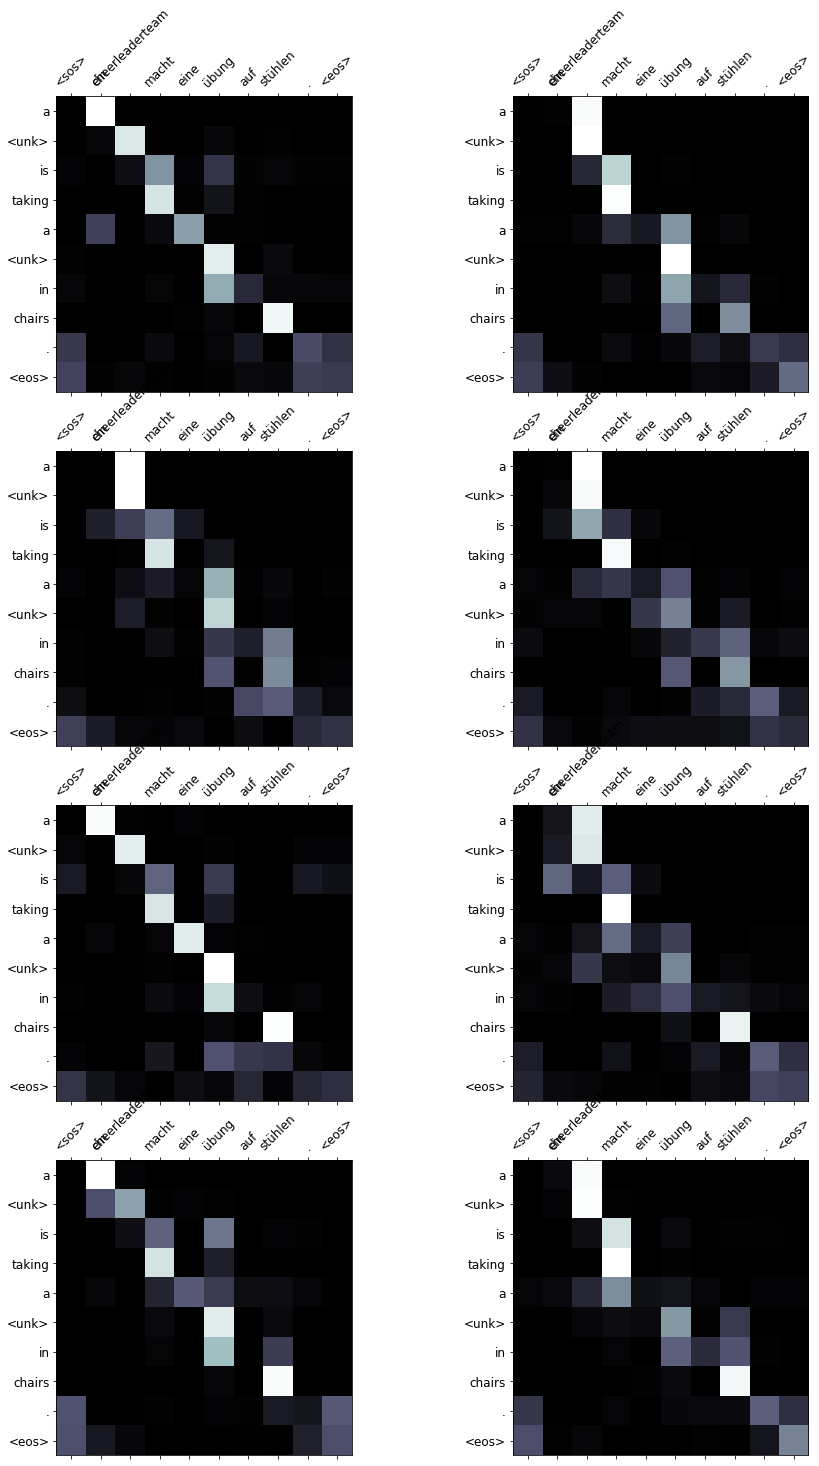

In [41]:
display_attention(src, translation, attention)